In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import cv2

plt.rcParams["figure.figsize"] = (15, 15)

In [2]:
def plot(image, name=None):
    _image = cv2.bitwise_not(image)
    plt.imshow(_image, cmap = 'gray')
    plt.axis("off")
    if name is not None:
        plt.savefig(f"output/{name}.png", cmap = 'gray', bbox_inches='tight', pad_inches=0)
    plt.show()

In [3]:
#Diretório para a leitura da imagem de referência
path = "./images"

#Imagem que será utilizada nos experimentos
image = None

#Leitura da imagem original
for obj in os.listdir(path):
    image_orig = io.imread(os.path.join(path, obj))

#Toma-se o negativo da imagem por conta dos operadores morfológicos
image = cv2.bitwise_not(image_orig)

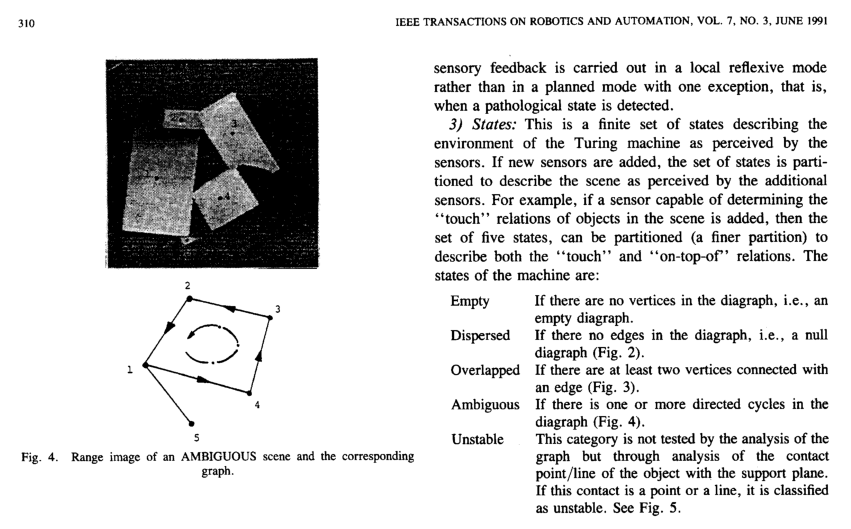

In [4]:
plot(image)

## 1) Dilatação da imagem original com um elemento estruturante de 1 pixel de altura e 100 pixels de largura

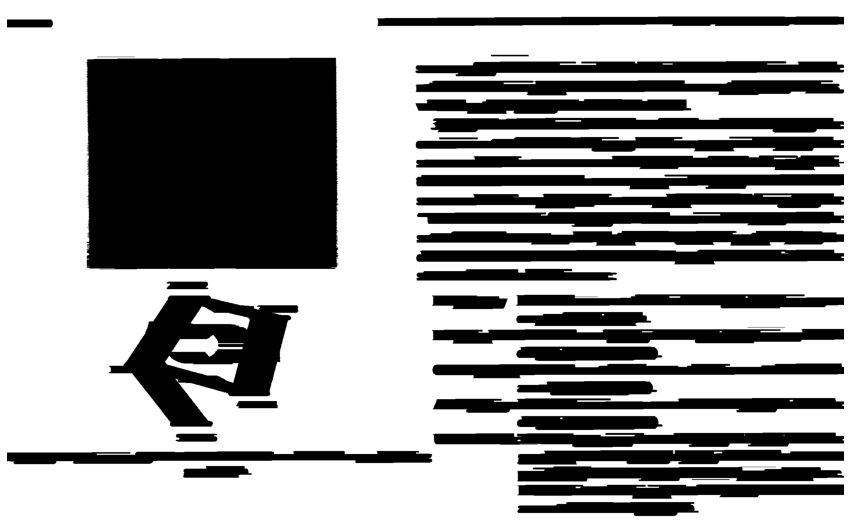

In [5]:
from skimage.morphology import rectangle
from skimage.morphology import dilation

#Aplicação da operação direta de dilatação com elemento estruturante 1 x 100
img_output_p1 = dilation(image, rectangle(1, 100))

plot(img_output_p1, "p1")

## 2) Erosão da imagem resultante com o mesmo elemento estruturante do passo (1)

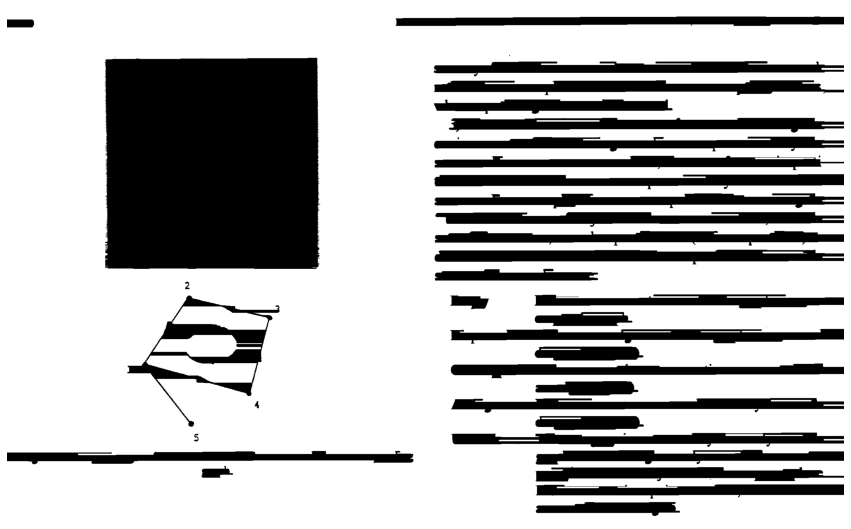

In [6]:
from skimage.morphology import erosion

#Aplicação da operação direta de erosão com elemento estruturante 1 x 100
img_output_p2 = erosion(img_output_p1, rectangle(1, 100))

plot(img_output_p2, "p2")

## 3) Dilatação da imagem original com um elemento estruturante de 200 pixels de altura e 1 pixel de largura

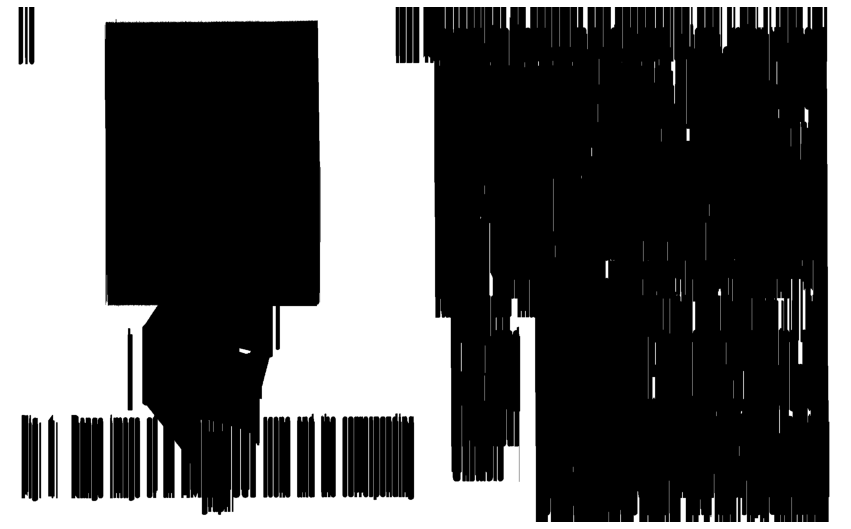

In [7]:
#Aplicação da operação direta de dilatação com elemento estruturante 200 x 1
img_output_p3 = dilation(image, rectangle(200, 1))

plot(img_output_p3, "p3")

## 4) Erosão da imagem resultante com o mesmo elemento estruturante do passo (3);

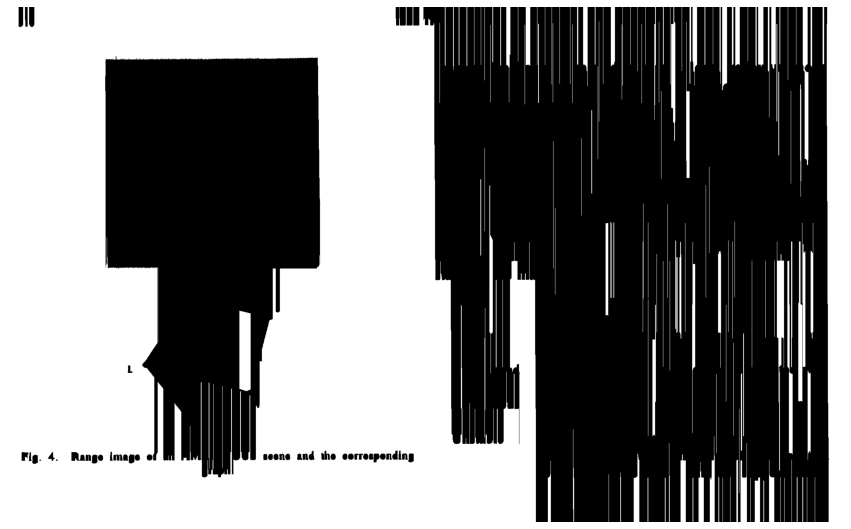

In [8]:
#Aplicação da operação direta de erosão com elemento estruturante 200 x 1
img_output_p4 = erosion(img_output_p3, rectangle(200, 1))

plot(img_output_p4, "p4")

## 5) aplicação da interseção (AND) dos resultados dos passos (2) e (4);

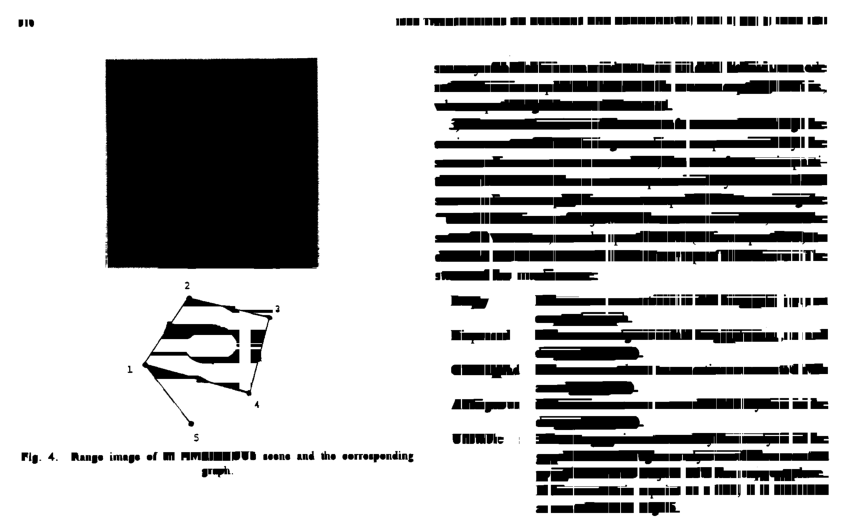

In [9]:
#Aplicação da operração AND para obter a interseccção dos resultados dos passos anteriores 
img_output_p5 = img_output_p2 & img_output_p4

plot(img_output_p5, "p5")

## 6) fechamento do resultado obtido no passo (5) com um elemento estruturante de 1 pixel de altura e 30 pixels de largura;

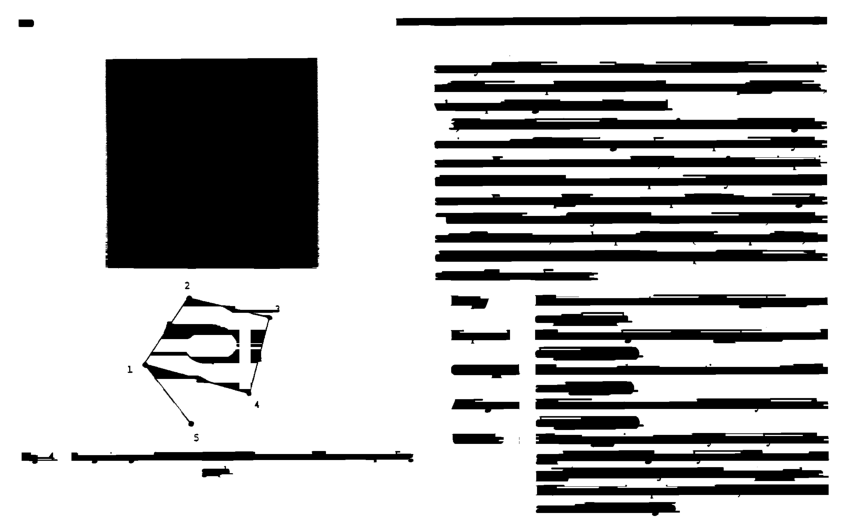

In [10]:
from skimage.morphology import closing

#Aplicação da operação direta de fechamento com elemento estruturante 1 x 30
img_output_p6 = closing(img_output_p5, rectangle(1, 30))

plot(img_output_p6, "p6")

## 7) aplicação  de  algoritmo  para  identificação  de  componentes  conexos  sobre  o  resultado  do passo (6);

In [11]:
#Identifica e retorna informações sobre as componentes conexas de uma certa imagem
def get_connected_componentes(image):
    _, _, stats, _ = cv2.connectedComponentsWithStats(image)
    return stats

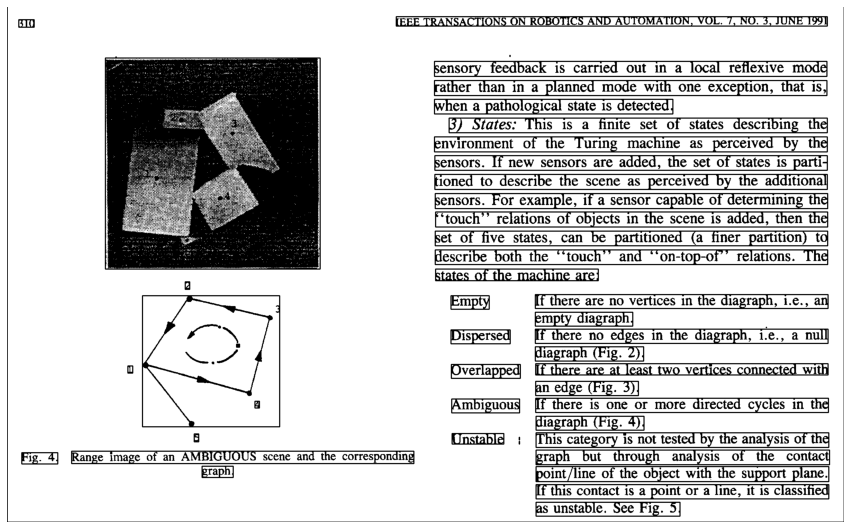

In [12]:
#Retorna as coordenadas das componentes conexas identificadas
componentes = get_connected_componentes(img_output_p6)

#Pega uma copia da imagem original para realizar os desenhos 
_image = cv2.bitwise_not(image.copy())

for box in componentes:
    x, y, w, h, _ = box
    cv2.rectangle(_image, (x, y), (x+w, y+h), (0, 0, 0), 2)

plt.imshow(_image, cmap='gray')
plt.axis("off")
plt.savefig("output/boxes.png", bbox_inches='tight', pad_inches=0)
plt.show()

## 8) para cada retângulo envolvendo um objeto, calcule  
- razão entre o numero de pixels pretos e o número total de pixels (altura x largura);
- razao entre o número de transicoes verticais e horizontais branco para preto e o numero total de pixels pretos;

In [13]:
def count_black_pixels(image, component):
    #Informações sobre o componente avaliado atualmente
    x, y, w, h, _ = component
    
    #recorte da imagem naquele componente
    image_cropped = image[y:(y+h+1), x:(x+w+1)]
    
    #Total de pixels no recorte 
    total = image_cropped.size
    
    #Quantidade de pixels pretos é igual à quantidade de pixels 
    #brancos na imagem original 
    #Lembrar: variável image é o negativo da imagem original!
    black_pixels = ((image_cropped == 255).sum())
    
    #Retorna a divisão de pixels pretos pelo total de pixels
    return black_pixels/total

def get_transitions_ratios(image, component):
    #Informações sobre o componente avaliado atualmente
    x, y, w, h, _ = component
    area = w*h
    
    #Número de transições 
    transitions = 0
    
    #Loop para verificar a quantidade de transições no bloco de texto
    for i in range(h-1):
        for j in range(w-1):
            #Ajusta os valores de linha e coluna
            row, col = y + i, x + j
            
            #Utilização da operação xor para verificar transações 
            #horizontais e verticais
            if bool(image[row, col]) ^ bool(image[row + 1, col]):
                transitions += 1
            if bool(image[row, col]) ^ bool(image[row, col + 1]):
                transitions += 1
    
    #Retorna a quatidade de transições dividido pela área 
    return transitions/(area)

## 9) criação de uma regra para classificar cada componente conexo, de acordo com as medidas obtidas no passo (8), como texto e não texto

In [14]:
def get_text_components(image, componentes):
    
    #Lista contendo os componentes classificados como texto
    text_boxes = []
    
    for component in componentes:
        #Informações sobre o componente atual
        x, y, w, h, _ = component
        
        #Calcula as razões 
        black_pixels_ratio = count_black_pixels(image, component)
        transations_ratio = get_transitions_ratios(image, component)
        MIN_BLACKPX_RATIO = 0.1 #0.2
        MAX_BLACKPX_RATIO = 0.5 #0.5
        MIN_TRANSAT_RATIO = 0.1 #0.2 - não encontra quase nenhum texto
        MAX_TRANSAT_RATIO = 0.4 #0.6
        
        #Regra de classificação em componente de texto
        if MIN_BLACKPX_RATIO < black_pixels_ratio < MAX_BLACKPX_RATIO and \
            MIN_TRANSAT_RATIO < transations_ratio < MAX_TRANSAT_RATIO:
            text_boxes.append(component)
    
    return text_boxes
    

In [15]:
def draw_boxes(image, boxes):
    for box in boxes:
        x, y, w, h, _ = box
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 0), 2)
    
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.savefig("output/p9.png", bbox_inches='tight', pad_inches=0)
    plt.show()

Quantidade de linhas encontradas: 39


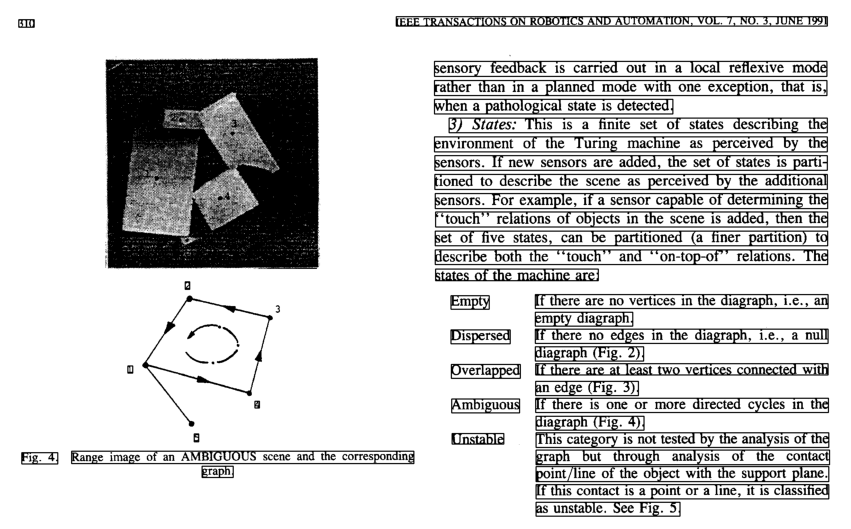

In [16]:
#Retorna a quantidade de blocos de texto encontrados
text_boxes = get_text_components(image, componentes)

print(f"Quantidade de linhas encontradas: {len(text_boxes)}")

#Destaca na imagem original os blocos encontrados
draw_boxes(image_orig.copy(), text_boxes)

## 10)aplicação de operadores morfologicos apropriados para segmentar cada linha do texto em blocos de palavras. Coloque um retângulo envolvendo cada palavra na imagem original. Calcule o numero total de linhas de texto e de blocos de palavras na imagem.

In [17]:
def process_words(image, boxes):
    
    #Elementos estruturantes para o processamento adequado dos blocos de palavras
    selem_1 = rectangle(5, 10) 
    selem_2 = rectangle(10, 5) 
    
    #Como recebe a imagem original, aplica-se operação not 
    image_not = cv2.bitwise_not(image)
    
    #Duas operações de dilatação para acenturar blocos de palavras
    dilated1 = dilation(image_not, selem_1)
    dilated1 = dilation(dilated1, selem_1)
    
    #Duas operações de dilatação para acenturar blocos de palavras
    dilated2 = dilation(image_not, selem_2)
    dilated2 = dilation(dilated2, selem_2)
    
    #interseção das dilatações realizadas
    intersection = dilated1 & dilated2
    
    #Lista de componentes representando palavras
    word_list = []
    
    for box in boxes: 
        #Informações sobre a componente atual
        x, y, w, h, _ = box
        
        #Crop da imagem na componente atual
        intersection_crop = intersection[y:y+h+1, x:x+w+1].copy()
        
        #Calcula as componentes conexas para a imagem de interseção
        words = get_connected_componentes(intersection_crop)[1:]
        
        #Ajusta as coordenadas (x,y) para cada componente
        for word in words:
            word[0] += x
            word[1] += y
            
        #Adiciona as componentes encontradas na lista de palavras
        word_list.extend(words)

    return word_list

Palavras encontradas: 245


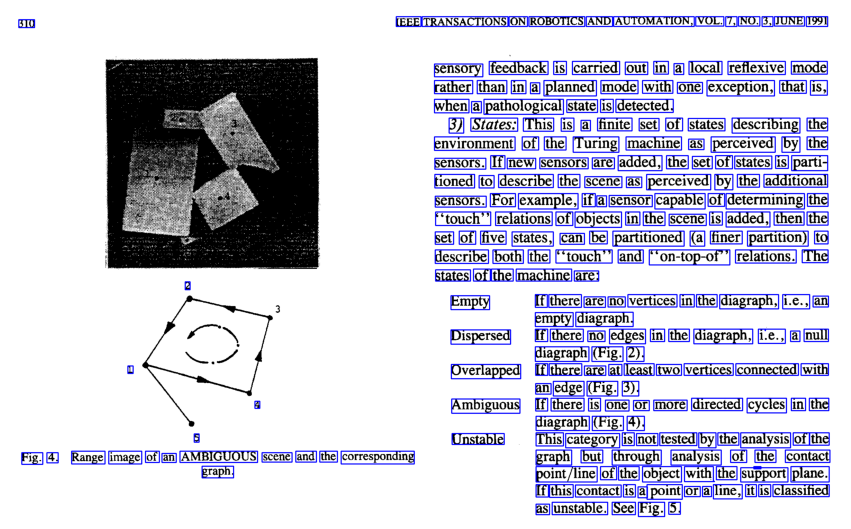

In [18]:
from skimage import color

#Retorna as palavras encontradas
words = process_words(image_orig, text_boxes)

#Converte a imagem original para RBG com finalidade de desenhar 
#boudind boxes coloridos
original_copy = color.gray2rgb(image_orig.copy())

#Desenha os bouding boxes com cor azul
for word in words:
    x, y, w, h, _ = word
    cv2.rectangle(original_copy, (x, y), (x+w, y+h), (0, 0, 255), 2)

print(f"Palavras encontradas: {len(words)}")
plt.figure()
plt.imshow(original_copy)
plt.axis("off")
plt.savefig("output/final.png", bbox_inches='tight', pad_inches=0)
plt.show()